# Random Forest
- Leo Breiman tarafında yazılan bir kütüphane.
- Temeli birden çok karar ağacın ürettiği tahminlerin bir araya getirlerek değerlendirmeye dayanır.
- Bagging ile Random Subspace yöntemlerinin birleşimidir.
- Ağaçlar ile gözlemler bootstrap rastgele örnek seçim yönremiyle değişkenler random subspace yöntemi ile seçilir.
- Karar ağacının her bir düğümünde en iyi dallara ayırıcı değişken tüm değişkenler arasından rastgele seçilen daha az sayıdaki değişken arasından seçilir.
- Ağaç oluşturmada veri setinin 2/3'ü kullanılır. Dışarıda kalan veri ağaçlarının performans değerlendirmesi ve değişken önemini belirlemek için kullanılır.
- Her düğüm noktasında rastgele değişkenler seçilir.

In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)

df = pd.read_csv("datasets/diabetes.csv")

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

#### Random Forests

In [4]:
rfModel = RandomForestClassifier(random_state=17)
rfModel.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

In [5]:
cvResults = cross_validate(rfModel, X, y, cv=10, scoring=["accuracy","f1","roc_auc"])
cvResults["test_accuracy"].mean()

0.753896103896104

In [6]:
cvResults["test_f1"].mean()

0.6190701534636385

In [7]:
cvResults["test_roc_auc"].mean()

0.8233960113960114

In [8]:
rfParams = {"max_depth": [5, 8, None],
             "max_features": [3, 5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 15, 20],
             "n_estimators": [100, 200, 500]}

In [9]:
rfBestGrid = GridSearchCV(rfModel, rfParams, cv=5, n_jobs=-1,verbose=True).fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [10]:
rfBestGrid.best_params_

{'max_depth': None,
 'max_features': 5,
 'min_samples_split': 8,
 'n_estimators': 500}

In [11]:
rfFinal = rfModel.set_params(**rfBestGrid.best_params_, random_state=17).fit(X, y)
cvResults = cross_validate(rfModel, X, y, cv=10, scoring=["accuracy","f1","roc_auc"])
cvResults["test_accuracy"].mean()

0.766848940533151

In [12]:
cvResults["test_f1"].mean()

0.6447777811143756

In [13]:
cvResults["test_roc_auc"].mean()

0.8271054131054132

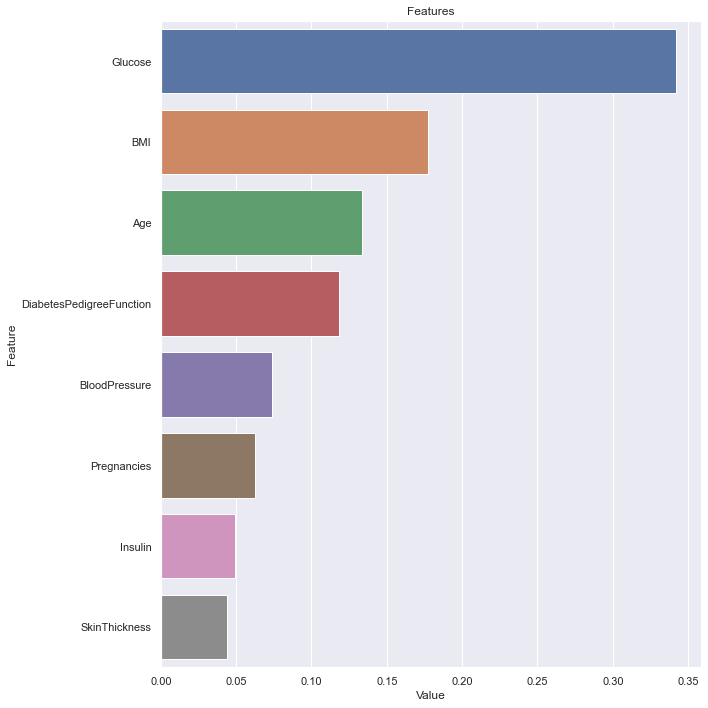

In [14]:
def plotImportance(model, features, num=len(X), save=False):
    featureImp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=featureImp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plotImportance(rfFinal, X)

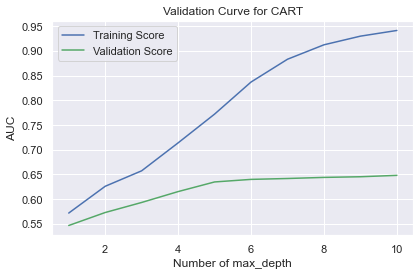

In [15]:
def valCurveParams(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    trainScore, testScore = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    meanTrainScore = np.mean(trainScore, axis=1)
    meanTestScore = np.mean(testScore, axis=1)
    plt.plot(range(1, 11), meanTrainScore,
            label="Training Score", color='b')

    plt.plot(range(1, 11), meanTestScore,
            label="Validation Score", color='g')

    plt.title("Validation Curve for CART")
    plt.xlabel("Number of max_depth")
    plt.ylabel("AUC")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show() 
valCurveParams(rfFinal, X, y, "max_depth", range(1, 11), scoring="f1")


# Gradient Boosting Machines(GBM)
### AdaBoost(Adaptive Boosting)
- Zayıf sınıflandırıcların bir araa gelerek güçlü sınıflandırıcılar oluşturmasına dayanır.
- GBM hatalar/artıklar üzerine tek bir model formunda olan modeller serisi kurulur.

In [16]:
gbmModel = GradientBoostingClassifier(random_state=17)
gbmModel.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 17,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [17]:
cvResults = cross_validate(gbmModel, X, y, cv=5, scoring=["accuracy","f1","roc_auc"])
cvResults["test_accuracy"].mean()

0.7591715474068416

In [18]:
cvResults["test_f1"].mean()

0.634235802826363

In [19]:
cvResults["test_roc_auc"].mean()

0.8254867225716283

In [20]:
gbmParams = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8, 10],
              "n_estimators": [100, 500, 1000],
              "subsample": [1, 0.5, 0.7]}

gbmBestGrid = GridSearchCV(gbmModel, gbmParams, cv=5, n_jobs=-1, verbose=True).fit(X, y)

gbmBestGrid.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.5}

In [21]:
gbmFinal = gbmModel.set_params(**gbmBestGrid.best_params_, random_state=17).fit(X, y)

In [22]:
cvResults = cross_validate(gbmFinal, X, y, cv=5, scoring=["accuracy","f1","roc_auc"])
cvResults["test_accuracy"].mean()

0.7800186741363212

In [23]:
cvResults["test_f1"].mean()

0.668605747317776

In [24]:
cvResults["test_roc_auc"].mean()

0.8257784765897973

# XGBoost(Extreme Gradient Boosting)
GBM'in hız ve tahmin performansını arttırmak üzere optimize edilmiş; ölçeklendirilmiş ve farklı platformlara entegre edilebilir bir versiyondur.

In [25]:
xGboostModel = XGBClassifier(random_state=17)

In [26]:
xGboostModel.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 17,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [27]:
cvResults = cross_validate(xGboostModel, X, y, cv=5, scoring=["accuracy","f1","roc_auc"])
cvResults["test_accuracy"].mean()

0.7526525761819879

In [28]:
cvResults["test_f1"].mean()

0.6317893713482235

In [29]:
cvResults["test_roc_auc"].mean()

0.7987134870719776

In [30]:
xgboostParams = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 500, 1000],
                  "colsample_bytree": [0.7, 1]}

In [31]:
xGboostBestGrid = GridSearchCV(xGboostModel, xgboostParams, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [32]:
xGboostFinal = xGboostModel.set_params(**xGboostBestGrid.best_params_, random_state=17).fit(X, y)

In [33]:
cvResults = cross_validate(xGboostFinal, X, y, cv=5, scoring=["accuracy","f1","roc_auc"])
cvResults["test_accuracy"].mean()

0.7578643578643579

In [34]:
cvResults["test_f1"].mean()

0.6297649135382188

In [35]:
cvResults["test_roc_auc"].mean()

0.8145597484276731

# LightGBM (Light Gradient Boosting)
- XGBoost'un eğitim süresi performansını arttırmaya yönelik geliştirilmiş bir versiyondur.
- Level-wise büyüme stratejisi yerine Leaf-wise büyüme stratejisi ile daha hızlıdır.

In [36]:
lgbmModel = LGBMClassifier(random_state=17)

In [37]:
lgbmModel.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 17,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [38]:
cvResults = cross_validate(lgbmModel, X, y, cv=5, scoring=["accuracy","f1","roc_auc"])
cvResults["test_accuracy"].mean()

0.7474492827434004

In [39]:
cvResults["test_f1"].mean()

0.624110522144179

In [40]:
cvResults["test_roc_auc"].mean()

0.7990293501048218

In [41]:
# Hiperparametre yeni değerlerle
lgbmParams = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}

lgbmBestGrid = GridSearchCV(lgbmModel, lgbmParams, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [42]:
lgbmFinal = lgbmModel.set_params(**lgbmBestGrid.best_params_, random_state=17).fit(X, y)

In [43]:
cvResults = cross_validate(lgbmFinal, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

cvResults['test_accuracy'].mean()

0.7643578643578645

In [44]:
cvResults['test_f1'].mean()

0.6372062920577772

In [45]:
cvResults['test_roc_auc'].mean()

0.8147491264849755

In [46]:
lgbmParams = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}

lgbmBestGrid = GridSearchCV(lgbmModel, lgbmParams, cv=5, n_jobs=-1, verbose=True).fit(X, y)
lgbmFinal = lgbmModel.set_params(**lgbmBestGrid.best_params_, random_state=17).fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [47]:
cvResults = cross_validate(lgbmFinal, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

cvResults['test_accuracy'].mean()

0.7643578643578645

In [48]:
cvResults['test_f1'].mean()

0.6372062920577772

In [49]:
cvResults['test_roc_auc'].mean()

0.8147491264849755

In [50]:
# Hiperparametre optimizasyonu sadece n_estimators için.
lgbmModel = LGBMClassifier(random_state=17, colsample_bytree=0.9, learning_rate=0.01)

lgbm_params = {"n_estimators": [200, 400, 1000, 5000, 8000, 9000, 10000]}

lgbmBestGrid = GridSearchCV(lgbmModel, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

lgbmFinal = lgbmModel.set_params(**lgbmBestGrid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(lgbmFinal, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

Fitting 5 folds for each of 7 candidates, totalling 35 fits


0.7643833290892115

In [51]:
cvResults['test_f1'].mean()

0.6372062920577772

In [52]:
cvResults['test_roc_auc'].mean()

0.8147491264849755

# CatBoost
- Kategorik değişkenlerle otomatik olarak mücadele edebilen, hızlı, başarılı bir GBM türevidir

In [53]:
catboostModel = CatBoostClassifier(random_state=17, verbose=False)

In [54]:
cvResults = cross_validate(catboostModel, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

cvResults['test_accuracy'].mean()

0.7735251676428148

In [55]:
cvResults['test_f1'].mean()

0.6502723851348231

In [56]:
cvResults['test_roc_auc'].mean()

0.8378923829489867

In [57]:
catboostParams = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}

In [58]:
catboostBestGrid = GridSearchCV(catboostModel, catboostParams, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [59]:
catboostFinal = catboostModel.set_params(**catboostBestGrid.best_params_, random_state=17).fit(X, y)

In [60]:
cvResults = cross_validate(catboostFinal, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

cvResults['test_accuracy'].mean()

0.7721755368814192

In [61]:
cvResults['test_f1'].mean()

0.6322580676028952

In [62]:
cvResults['test_roc_auc'].mean()

0.842001397624039

# Feature Importance

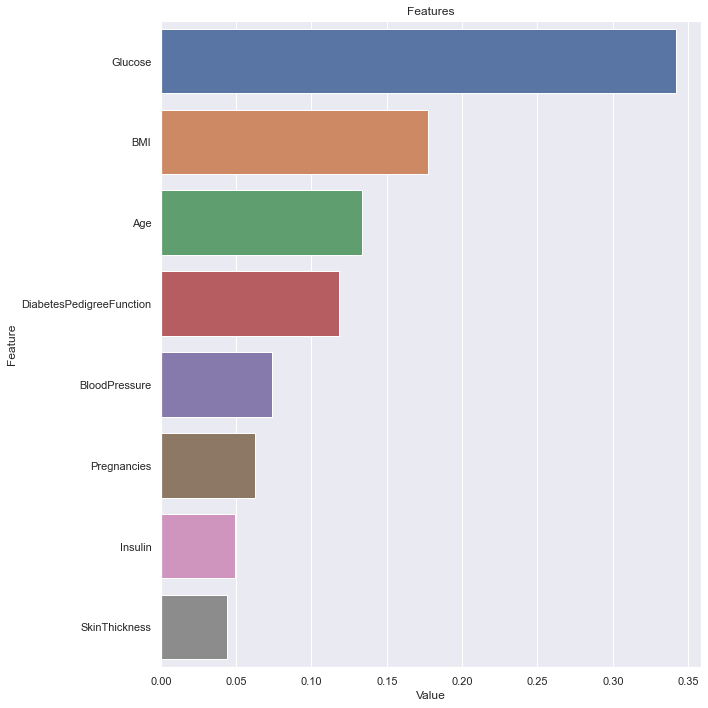

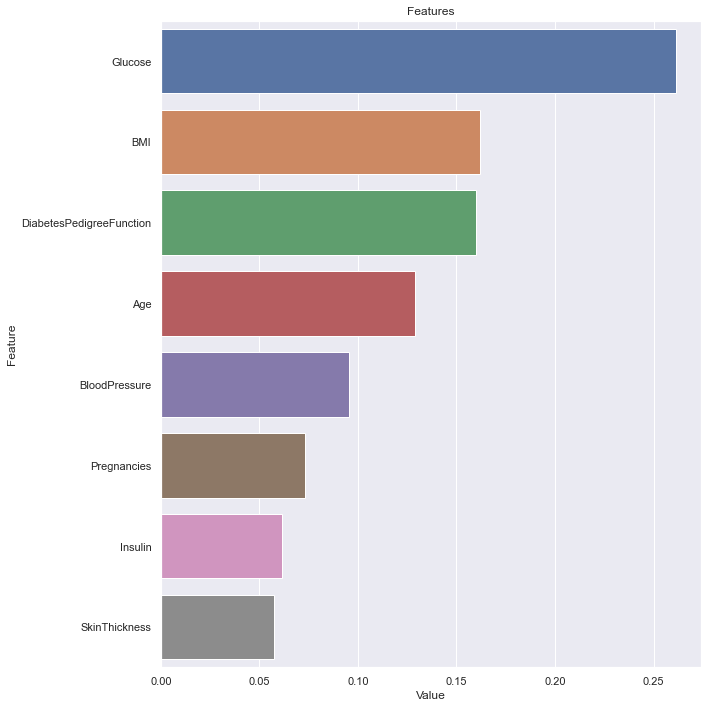

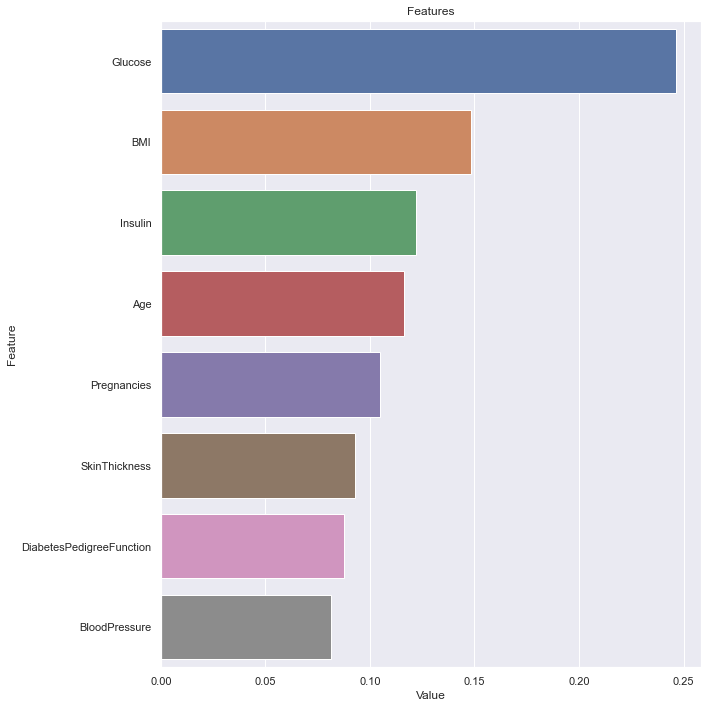

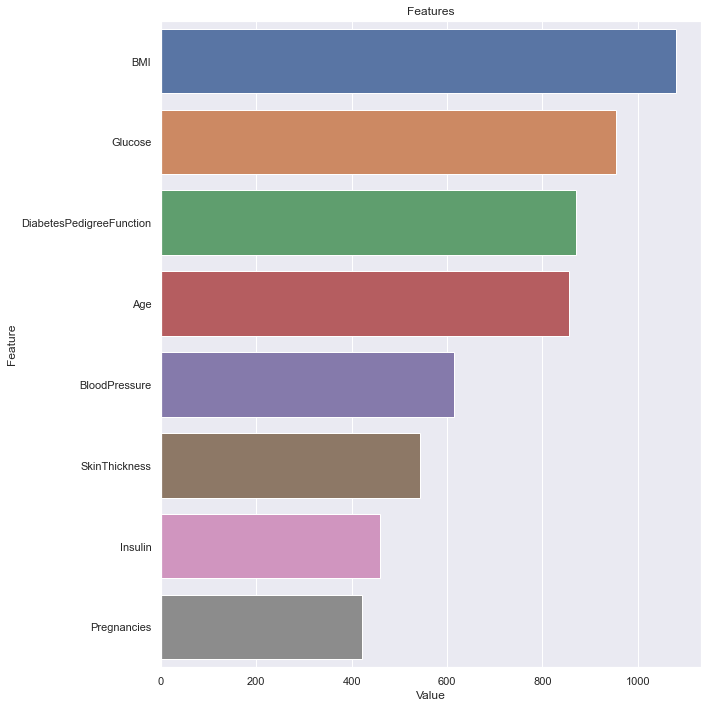

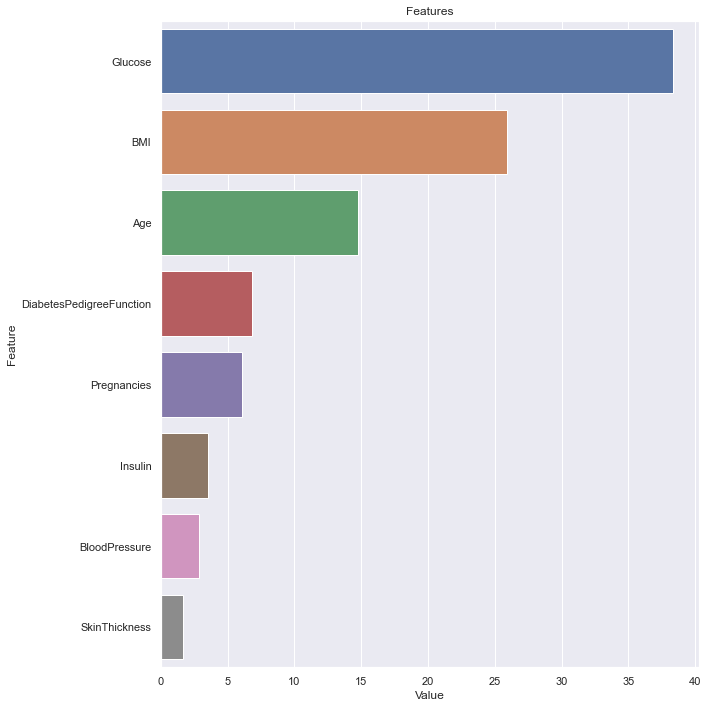

In [63]:
def plotImportance(model, features, num=len(X), save=False):
    featureImp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=featureImp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plotImportance(rfFinal, X)
plotImportance(gbmFinal, X)
plotImportance(xGboostFinal, X)
plotImportance(lgbmFinal, X)
plotImportance(catboostFinal, X)


**Hyperparameter Optimization with RandomSearchCV (BONUS)**

In [64]:
rfModel = RandomForestClassifier(random_state=17)

rfRandomParams = {"max_depth": np.random.randint(5, 50, 10),
                    "max_features": [3, 5, 7, "auto", "sqrt"],
                    "min_samples_split": np.random.randint(2, 50, 20),
                    "n_estimators": [int(x) for x in np.linspace(start=200, stop=1500, num=10)]}

rfRandom = RandomizedSearchCV(estimator=rfModel,
                               param_distributions=rfRandomParams,
                               n_iter=100,  # denenecek parametre sayısı
                               cv=3,
                               verbose=True,
                               random_state=42,
                               n_jobs=-1)

rfRandom.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=17),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': array([45, 36, 38, 39, 26, 32, 16, 44, 16,  8]),
                                        'max_features': [3, 5, 7, 'auto',
                                                         'sqrt'],
                                        'min_samples_split': array([42, 24, 19,  7,  7, 19, 28, 20, 31,  3, 30,  3, 13, 47, 29, 29, 39,
       48, 20, 36]),
                                        'n_estimators': [200, 344, 488, 633,
                                                         777, 922, 1066, 1211,
                                                         1355, 1500]},
                   random_state=42, verbose=True)

In [65]:
rfRandom.best_params_

{'n_estimators': 200,
 'min_samples_split': 28,
 'max_features': 'sqrt',
 'max_depth': 45}

In [66]:
rfRandomFinal = rfModel.set_params(**rfRandom.best_params_, random_state=17).fit(X, y)

In [67]:
cvResults = cross_validate(rfRandomFinal, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
cvResults['test_accuracy'].mean()

0.7682879212290977

In [68]:
cvResults['test_f1'].mean()

0.6293202548677237

In [69]:
cvResults['test_roc_auc'].mean()

0.8361495457721873

**Analyzing Model Complexity with Learning Curves (BONUS)**

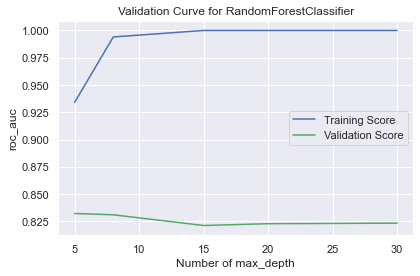

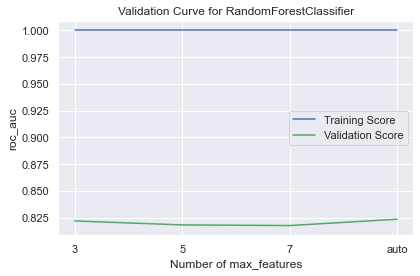

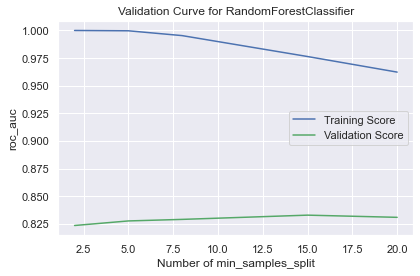

In [70]:
def valCurveParams(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)
    
rfValParams = [["max_depth", [5, 8, 15, 20, 30, None]],
                 ["max_features", [3, 5, 7, "auto"]],
                 ["min_samples_split", [2, 5, 8, 15, 20]],
                 ["n_estimators", [10, 50, 100, 200, 500]]]


rfModel = RandomForestClassifier(random_state=17)

for i in range(len(rfValParams)):
    valCurveParams(rfModel, X, y, rfValParams[i][0], rfValParams[i][1])

rfValParams[0][1]
